# Camera calibration with sample video footage

ref: https://docs.opencv.org/4.x/dd/d43/tutorial_py_video_display.html

In [1]:
import numpy as np
import cv2 
import os
import math

import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv2
import json
import time
import glob
import sys

## Get .mp4 files

In [2]:
video_path = os.path.join('..','..','datasets','NokiaVillarceauxVideoFeed/CALIBRATION')
video_path

'../../datasets/NokiaVillarceauxVideoFeed/CALIBRATION'

In [3]:
!ls '../../datasets/NokiaVillarceauxVideoFeed/CALIBRATION'

BOU-EXT-NORD-OUEST_2022-06-30_14h22min38s747ms.mp4
GAL-EXT-NORD-OUEST_2022-06-30_14h10min43s943ms.mp4
GAL-EXT-NORD-OUEST_2022-06-30_14h30min43s947ms.mp4


In [4]:
filenames = []
dirnames = []
for (_dirpath, _dirnames, _filenames) in os.walk(video_path):
    filenames.extend(_filenames)
    dirnames.extend(_dirnames)
    break

In [5]:
filenames

['GAL-EXT-NORD-OUEST_2022-06-30_14h10min43s943ms.mp4',
 'BOU-EXT-NORD-OUEST_2022-06-30_14h22min38s747ms.mp4',
 'GAL-EXT-NORD-OUEST_2022-06-30_14h30min43s947ms.mp4']

Let's work with the BOU camera

In [6]:
filepath = os.path.join(video_path, filenames[1])
filepath

'../../datasets/NokiaVillarceauxVideoFeed/CALIBRATION/BOU-EXT-NORD-OUEST_2022-06-30_14h22min38s747ms.mp4'

## Processing footage

In [7]:
# extract a frame
def get_frame_old(path_in, get_time, eps = 0.1, speed = 1, max_it = 1e5, 
             plot_img = True , figsize = (15,15), verbose = 0):

    
    # open video with cv2
    vidcap = cv2.VideoCapture(path_in)
    
    # Convert the resolutions from float to integer.
    frame_width = int(vidcap.get(3))
    frame_height = int(vidcap.get(4))
    
    # Get number of frames
    length = int(vidcap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    # Get fps rate
    fps = vidcap.get(cv2.CAP_PROP_FPS)

    if verbose > 0:
        print ('Video width: {}, video heigth = {}'.format(frame_width, frame_height))
        print ('Video length in frames: {}, video fps rate = {} [s^-1], play time = {} [s]'.format(length, fps, length/fps))

    success,image = vidcap.read()
    success = True
    
    frame_found = False
    count = 0
    image = None
    while success:     
        frame_number = count*speed
        time = frame_number/fps
        vidcap.set(cv2.CAP_PROP_POS_MSEC,(frame_number))    # added this line 
        success,image = vidcap.read()
        
        if verbose > 0:
            print ('Frame read: frame = {} , iteration = {}, time = {:.2f} [s]'.format(frame_number, count, frame_number/fps))
        
        if abs(time - get_time) < eps:
            frame_found = True
            break
        if time > get_time + eps:
            if verbose > 0:
                print ('Failure: Did not find frame.')
            break
        if count >= max_it:
            if verbose > 0:
                print('Failure: Max iterations achieved')
            break
        # add one iteration to count
        count = count + 1

    
    if frame_found:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if plot_img:
            plt.figure(figsize=figsize)
            plt.imshow(image)
            plt.axis('off')
            plt.show()
        return image
    else:
        return None

timestamp; fps; nframes

nframes/fps = dt

timestamp/dt = framestamp



In [8]:
# extract a frame
def get_frame(path_in, time_of_interest, plot_img = True , figsize = (15,15), verbose = 0):
    # open video with cv2
    vidcap = cv2.VideoCapture(path_in)
    
    # Convert the resolutions from float to integer.
    frame_width = int(vidcap.get(3))
    frame_height = int(vidcap.get(4))
    
    # Get number of frames
    nframes = int(vidcap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    # Get fps rate
    fps = vidcap.get(cv2.CAP_PROP_FPS)

    if verbose > 0:
        print ('Video width: {}, video heigth = {}'.format(frame_width, frame_height))
        print ('Video length in frames: {}, video fps rate = {} [s^-1], play time = {} [s]'.format(nframes, fps, nframes/fps))

    success,image = vidcap.read()
    success = True
    
    frame_found = False
    image = None
    
    # calculate frame of the timestamp
    dt = 1/fps
    frame_of_interest = int(time_of_interest/dt)
    print(dt)
    # read video file
    vidcap.set(cv2.CAP_PROP_POS_MSEC,(frame_of_interest))    # added this line 
    success,image = vidcap.read()
    if success:         
        if verbose > 0:
            print ('Frame Found: frame = {} , time captured = {:.2f} [s]'.format(frame_of_interest, frame_of_interest*dt))
        # assume succcess
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if plot_img:
            plt.figure(figsize=figsize)
            plt.imshow(image)
            plt.axis('off')
            plt.show()
        return image
    else:
        return None

Video width: 1920, video heigth = 1080
Video length in frames: 17792, video fps rate = 14.984755840786969 [s^-1], play time = 1187.3400000000001 [s]
0.06673448741007194
Frame Found: frame = 1498 , time captured = 99.97 [s]


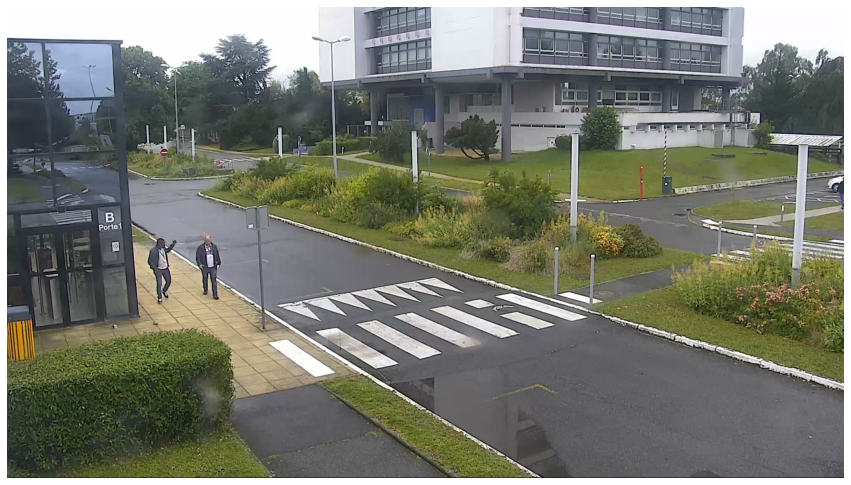

In [9]:
test_img = get_frame(filepath, time_of_interest = 100, verbose = 1)

# Calibration

# To make a correspondence between cam coordinates and world coordinates we need to associate image points with the world map

In [10]:
# camera resolution in pixels
heigth_res = 1080 # Image width in pixels
width_res = 1920 # Image height in pixels

gt_pixel_coords = []
gt_pixel_coords.append((int(width_res/2),int(heigth_res/2)))
gt_pixel_coords.append((550,580))
gt_pixel_coords.append((1150,600))
gt_pixel_coords.append((1310,740))
gt_pixel_coords.append((1180,820))

# WE MEASURE THE FOLLOWING POLAR COORDINATES USING THE CHART FROM THE CAMPUS

# polar coordinates ground truth need to be adjusted wrp to camera center coordinates
CAM_CENTER_POLAR_GT = (39,229) # polar coordinates: (39,/_0) | pixel coordinates: (960, 540)
CAM_CENTER_REF_GT_ANGLE = 229 # In degrees

# get points using polar coordinates + plans
gt_polar_1 = (33.387, 219) # polar coordinates: (33.387,/_219) | pixel coordinates: 550,580
gt_polar_2 = (28.364, 237.7) # polar coordinates: (28.364,/_237.7) | pixel coordinates: 1150,600
gt_polar_3 = (25.4, 240) # polar coordinates: (25.4,/_240) | pixel coordinates: 1310,740
gt_polar_4 = (20.78, 236.4) # polar coordinates: (20.78,/_236.4) | pixel coordinates: 1180,820

gt_polar_measures = []
gt_polar_measures.append(CAM_CENTER_POLAR_GT)
gt_polar_measures.append(gt_polar_1)
gt_polar_measures.append(gt_polar_2)
gt_polar_measures.append(gt_polar_3)
gt_polar_measures.append(gt_polar_4)

# We must correct the polar coordinates to the camera frame.

gt_polar_measures = [(r, alpha - CAM_CENTER_REF_GT_ANGLE) for r, alpha in gt_polar_measures]

# Finally we transform the points to cartesian coordinates in the camera frame.

# polar to cartesian: (r,/_alpha) in degrees to (x,y) in cartesian
_cart = lambda _r, _alpha : (np.cos(math.radians(_alpha))*_r, np.sin(math.radians(_alpha))*_r)

gt_cartesian_measures = [_cart(r,alpha) for r, alpha in gt_polar_measures]

# We can plot the gt points in polar cordinates

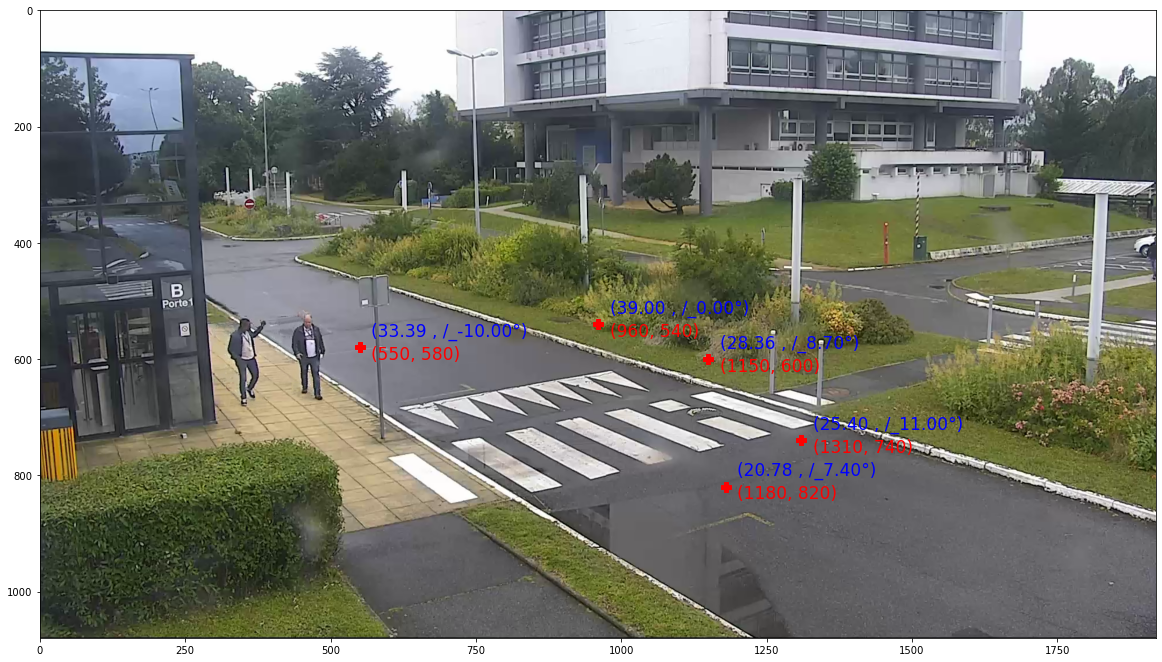

In [11]:
alfa = 20
plt.figure(figsize=(20,20))
plt.imshow(test_img)

# plot pixel and polar coordinates
for pixel_coord, polar_coord in zip(gt_pixel_coords, gt_polar_measures):
    label_pixel_coord = str((pixel_coord[0],pixel_coord[1]))
    label_polar_coord = '({:.2f} , /_{:.2f}°)'.format(polar_coord[0],polar_coord[1])

    plt.plot(pixel_coord[0], pixel_coord[1], 'P', c = 'r', markersize = '10')
    plt.text(pixel_coord[0]+alfa, pixel_coord[1]+alfa, label_pixel_coord, c = 'r', fontsize = 17)
    plt.text(pixel_coord[0]+alfa, pixel_coord[1]-alfa, label_polar_coord, c = 'b', fontsize = 17)


plt.axis('on')
plt.show()

# Or in cartesian, which is what we will use

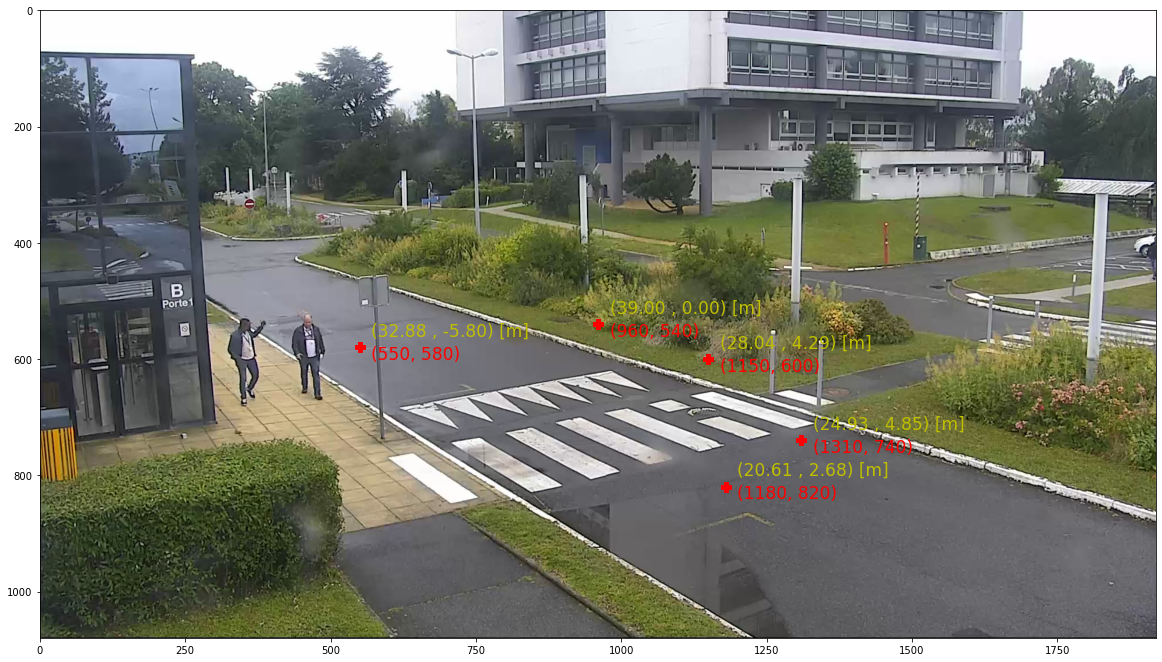

In [12]:
alfa = 20
plt.figure(figsize=(20,20))
plt.imshow(test_img)

# plot pixel and cartesian coordinates
for pixel_coord, cart_coord in zip(gt_pixel_coords, gt_cartesian_measures):
    label_pixel_coord = str((pixel_coord[0],pixel_coord[1]))
    label_cart_coord = '({:.2f} , {:.2f}) [m]'.format(cart_coord[0],cart_coord[1])

    plt.plot(pixel_coord[0], pixel_coord[1], 'P', c = 'r', markersize = '10')
    plt.text(pixel_coord[0]+alfa, pixel_coord[1]+alfa, label_pixel_coord, c = 'r', fontsize = 17)
    plt.text(pixel_coord[0]+alfa, pixel_coord[1]-alfa, label_cart_coord, c = 'y', fontsize = 17)


plt.axis('on')
plt.show()

# We can analiticaly obtain the pitch of the camera using the principal axis 

In [70]:
90 - math.degrees(np.arctan(39/5))

7.30575953331082

In [72]:
def analytical_pitch(Z,X):
    """
    :return: pitch in degrees
    """
    return 90 - math.degrees(np.arctan(Z/X))
    

In [71]:
def analytical_pitch_2(Z,X,):
    """
    :return: pitch in degrees
    """
    gamma_1 = (Z+X*np.sqrt(1+Z**2-X**2))/((Z**2-X**2))
    gamma_2 = (Z-X*np.sqrt(1+Z**2-X**2))/((Z**2-X**2))

    return math.degrees(np.arccos(gamma_1)), math.degrees(np.arccos(gamma_2))
    

In [79]:
Z = 39
X = 5
analytical_pitch(Z,X)

7.30575953331082

# Analytical projection

In [84]:
# camera resolution in pixels
HEIGTH_RES = 1080 # Image width in pixels
WIDTH_RES = 1920 # Image height in pixels

# center of image (in image coordinates)
CAM_CENTER =  (WIDTH_RES/2, HEIGTH_RES/2)

# field of view in degrees
FOV_H = 62.8 # FOV in degrees
FOV_W = 36.8 # FOV in degrees

# camera tilt in degrees
W = 7

# camera altitude
CAMERA_ALTITUDE = 5

# calculate the focal lenght
FL_H = (HEIGTH_RES/2)/(np.tan(np.deg2rad(FOV_H/2)))
FL_W = (WIDTH_RES/2)/(np.tan(np.deg2rad(FOV_W/2)))

# coordinates of the camera in real world
CAMERA_COORDS = (0, 0)

In [81]:
np.cos(math.radians(7.3))

0.9918944425900297

In [96]:
C = np.matrix([[1/FL_H, 0, 0],
               [0, 1/FL_W, 0],
               [0, 0, 1]])
C

matrix([[1.1303752e-03, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 3.4651638e-04, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 1.0000000e+00]])

In [97]:
C*np.array([[5],
            [0],
            [39]])

matrix([[5.65187599e-03],
        [0.00000000e+00],
        [3.90000000e+01]])

In [92]:
inv_C = np.linalg.inv(C)
inv_C

matrix([[1.1303752e-03, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 3.4651638e-04, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 1.0000000e+00]])

In [94]:
C*np.array([[0],
            [0],
            [1]])

matrix([[0.],
        [0.],
        [1.]])

In [ ]:
def analytical_cam_eq():
    """
    :return: pitch in degrees
    """
    return 90 - math.degrees(np.arctan(Z/X))
    

In [66]:
Z = 32.88
X = 5
analytical_pitch(Z,X)

(79.335142488892, 97.05353756211095)

In [67]:
Z = 28.04
X = 5
analytical_pitch(Z,X)

(77.39815626205075, 98.30864623409927)

In [68]:
Z = 20.61
X = 5
analytical_pitch(Z,X)

(72.4259471842114, 101.4685166875192)

## TEST 2

# Cam params

**Lens** 4.44-142.6 mm, F1.6-4.41

**Horizontal angle of view:** 62.8˚- 2.23˚

**Vertical angle of view:** 36.8˚- 1.3˚

**Camera world position:** Needs validation but for now we set it as (0,0)

**Camera tilt and camera altitude:** Should be determined experimentally either by callibration or preferably by measures on the ground

In [13]:
# camera resolution in pixels
HEIGTH_RES = 1080 # Image width in pixels
WIDTH_RES = 1920 # Image height in pixels

# center of image (in image coordinates)
CAM_CENTER =  (WIDTH_RES/2, HEIGTH_RES/2)

# field of view in degrees
FOV_H = 62.8 # FOV in degrees
FOV_W = 36.8 # FOV in degrees

# camera tilt in degrees
W = 7

# camera altitude
CAMERA_ALTITUDE = 5

# calculate the focal lenght
FL_H = (HEIGTH_RES/2)/(np.tan(np.deg2rad(FOV_H/2)))
FL_W = (WIDTH_RES/2)/(np.tan(np.deg2rad(FOV_W/2)))

# coordinates of the camera in real world
CAMERA_COORDS = (0, 0)

# Distance estimation functions

In [14]:
def get_object_pos(obj_img_coords, camera_altitude = CAMERA_ALTITUDE, 
                   camera_tilt = W, cam_center = CAM_CENTER, fl_w = FL_H, fl_h= FL_W):
    """
     calculate object coordinates in the plane projected onto image
    :obj_img_coords: image coordinates of object 
    :camera_altitude: camera altitude in radial earth direction
    :camera_tilt: camera tilt wrp to orthogonal plane to radial earth direction
    :cam_center: camera center in pixel coordinates
    :fl_w: width focal lenght
    :fl_w: width focal lenght
    :fl_h: heigth focal lenght
    :return: relative coordinates to camera plane
    """ 
    
    # calculate heigth object angle in degrees
    theta_h = math.degrees(np.arctan((obj_img_coords[1] - cam_center[1])/fl_h))
    
    # account for tilt
    theta_h_tilt = theta_h + camera_tilt

    # calculate distance from car to camera
    I = camera_altitude/np.tan(math.radians(theta_h_tilt))

    # calculate heigth object angle
    tan_theta_w = (obj_img_coords[0]-cam_center[0])/(fl_w)

    # calculate distance of car to central axis 
    J = tan_theta_w*I

    return (I, J)
    

In [15]:
def get_bb_center(bb):
    """
     calculate object center based upon it's bounding box coordinates
    :bb: image coordinates of bounding box are assumed to be first 4 entries of bb
    :return: center of bounding box 
    """     
    ul = (bb[0], bb[1])
    lr = (bb[2], bb[3])
    center_coord = ( ul[0] + (lr[0] - ul[0])/2, ul[1] + (lr[1] - ul[1])/2)
    return center_coord

In [16]:
def plot_object_center(img, prediction, figsize = (10,10)):
    plt.figure(figsize=figsize)
    
    
    # plot bbox
    plt.plot(prediction[0],prediction[1], 'x', c = 'y', markersize = '10')
    plt.plot(prediction[2],prediction[3], 'x', c = 'y', markersize = '10')
    
    
    # plot bbox center
    center_coords = get_bb_center(prediction)
    plt.plot(center_coords[0],center_coords[1], 'o', c = 'r', markersize = '10')

    plt.imshow(img)
    plt.show()

# Using ground truth points

In [17]:
gt_pixel_coords

[(960, 540), (550, 580), (1150, 600), (1310, 740), (1180, 820)]

In [18]:
gt_cartesian_measures

[(39.0, 0.0),
 (32.87977644981859, -5.797591707765803),
 (28.0376406054415, 4.29036190549212),
 (24.933330459570662, 4.846548482564238),
 (20.606926754320618, 2.676372496881757)]

## Study influence of camera tilt
Using center point to calibrate tilt angle

<ipython-input-14-148d870d9094>:22: RuntimeWarning: divide by zero encountered in double_scalars
  I = camera_altitude/np.tan(math.radians(theta_h_tilt))
<ipython-input-14-148d870d9094>:28: RuntimeWarning: invalid value encountered in double_scalars
  J = tan_theta_w*I


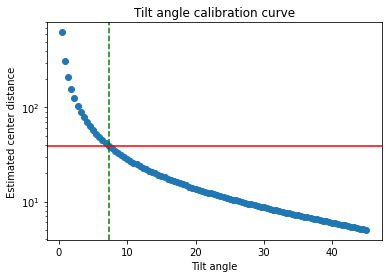

In [78]:
N = 100

# fix heigth and width dim and vary camera tilt

tilt_angle = np.linspace(0, 45, N, endpoint = True)
I_dist_estimation = [get_object_pos(gt_pixel_coords[0],camera_tilt = tilt)[0] for tilt in tilt_angle]

plt.title("Tilt angle calibration curve")

# i is the distance to depth plane and j is the distance inside depth plane
plt.plot(tilt_angle, I_dist_estimation, 'o')
# set y axis scale to log
plt.yscale('log')
# plot the ground truth
plt.axhline(y=39, color='r', linestyle='-')

# try to manually fit the ground truth
plt.axvline(x=7.3, color='g', linestyle='--')

plt.xlabel("Tilt angle")
plt.ylabel("Estimated center distance")

plt.show()

Let's set the camera tilt angle based upon prediction

In [76]:
W = 7.3

In [77]:
coords_estimation = [get_object_pos(pixel, camera_tilt = W) for pixel in gt_pixel_coords]
for idx, (pixel, gt) in enumerate(zip(gt_pixel_coords, gt_cartesian_measures)):
    print('TEST {}:'.format(idx))
    print('pixel coordinates = {} '.format(pixel))
    print('ground truth = {} [m]'.format(gt))
    print('estimation = {} [m]'.format(coords_estimation[idx]))
    print('#########################')

TEST 0:
pixel coordinates = (960, 540) 
ground truth = (39.0, 0.0) [m]
estimation = (39.031106045506974, 0.0) [m]
#########################
TEST 1:
pixel coordinates = (550, 580) 
ground truth = (32.87977644981859, -5.797591707765803) [m]
estimation = (35.157756684964106, -16.29399703275045) [m]
#########################
TEST 2:
pixel coordinates = (1150, 600) 
ground truth = (28.0376406054415, 4.29036190549212) [m]
estimation = (33.49151188692956, 7.193015132918658) [m]
#########################
TEST 3:
pixel coordinates = (1310, 740) 
ground truth = (24.933330459570662, 4.846548482564238) [m]
estimation = (25.10361612769851, 9.931776768661306) [m]
#########################
TEST 4:
pixel coordinates = (1180, 820) 
ground truth = (20.606926754320618, 2.676372496881757) [m]
estimation = (21.93358619546267, 5.454500004952024) [m]
#########################


## Study influence of camera altitude

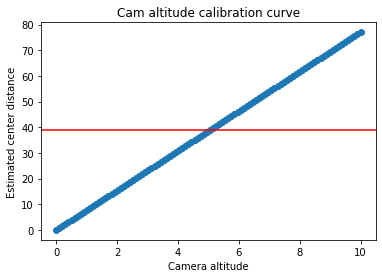

In [22]:
N = 100
# fix heigth and width dim and vary camera tilt

cam_altitudes = np.linspace(0, 10, N, endpoint = True)
I_dist_estimation = [get_object_pos(gt_pixel_coords[0],camera_tilt = W, camera_altitude = alt)[0] for alt in cam_altitudes]

plt.title("Cam altitude calibration curve")

# i is the distance to depth plane and j is the distance inside depth plane
plt.plot(cam_altitudes, I_dist_estimation, 'o')
# plot the ground truth
plt.axhline(y=39, color='r', linestyle='-')

plt.xlabel("Camera altitude")
plt.ylabel("Estimated center distance")

plt.show()

## Study influence of field of view

### Heigth FOV

In [23]:
# calculate the focal lenght

FL_H = (HEIGTH_RES/2)/(np.tan(np.deg2rad(FOV_H/2)))
FL_W = (WIDTH_RES/2)/(np.tan(np.deg2rad(FOV_W/2)))

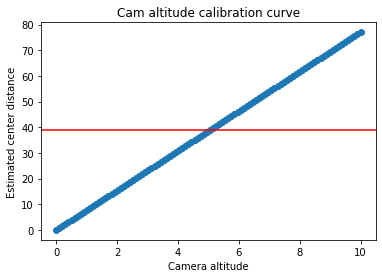

In [24]:
N = 100
# fix heigth and width dim and vary camera tilt

FOV_H = np.linspace(0, 1, N, endpoint = True)
I_dist_estimation = [get_object_pos(gt_pixel_coords[0],camera_tilt = W, camera_altitude = alt)[0] for alt in cam_altitudes]

plt.title("Cam altitude calibration curve")

# i is the distance to depth plane and j is the distance inside depth plane
plt.plot(cam_altitudes, I_dist_estimation, 'o')
# plot the ground truth
plt.axhline(y=39, color='r', linestyle='-')

plt.xlabel("Camera altitude")
plt.ylabel("Estimated center distance")

plt.show()

## Error estimation

In [25]:
coords_estimation = [get_object_pos(pixel, camera_tilt = W) for pixel in gt_pixel_coords]
error = []
for idx, (pixel, gt) in enumerate(zip(gt_pixel_coords, gt_cartesian_measures)):
    error.append((gt[0]-coords_estimation[idx][0], gt[1]-coords_estimation[idx][1]))
    

In [26]:
error

[(0.5021324977562429, 0.0),
 (-1.8431208268635757, 10.294868066174281),
 (-5.058228925864146, -2.817680609264829),
 (0.056432862535775286, -4.995531334693103),
 (-1.1513454985935745, -2.7345299909120078)]

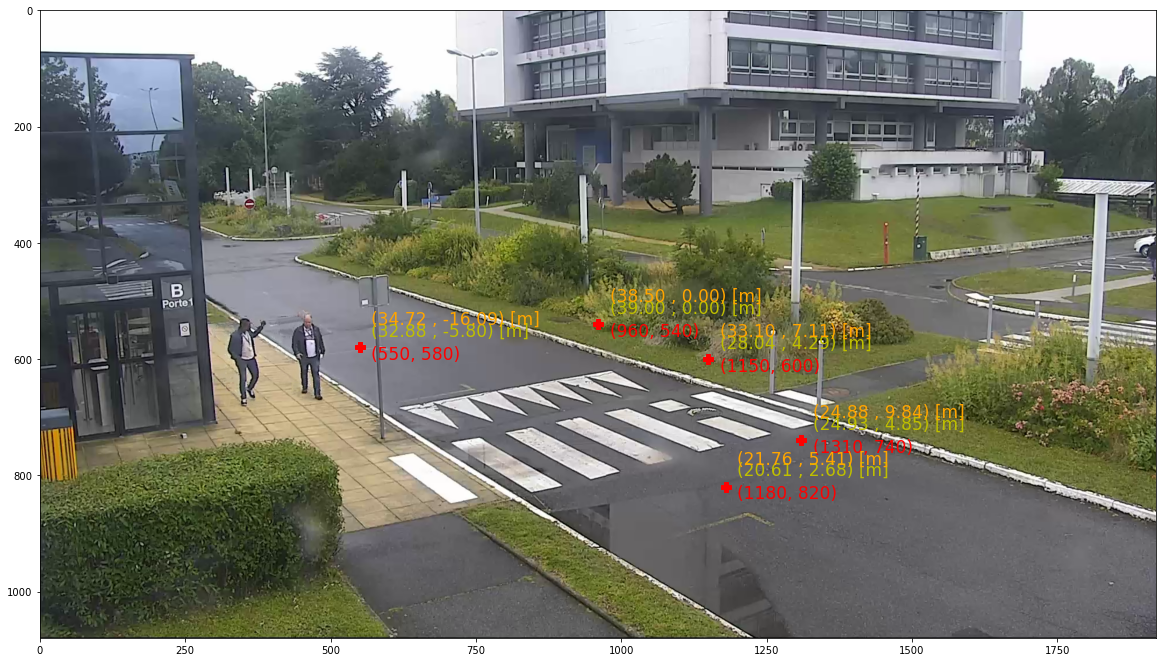

In [27]:
alfa = 20
plt.figure(figsize=(20,20))
plt.imshow(test_img)

# plot pixel and cartesian coordinates
for pixel_coord, gt_cart_coord, estimation in zip(gt_pixel_coords, gt_cartesian_measures, coords_estimation):
    label_pixel_coord = str((pixel_coord[0],pixel_coord[1]))
    label_gt_cart_coord = '({:.2f} , {:.2f}) [m]'.format(gt_cart_coord[0],gt_cart_coord[1])
    label_estimation_coord = '({:.2f} , {:.2f}) [m]'.format(estimation[0],estimation[1])
    plt.plot(pixel_coord[0], pixel_coord[1], 'P', c = 'r', markersize = '10')
    plt.text(pixel_coord[0]+alfa, pixel_coord[1]+alfa, label_pixel_coord, c = 'r', fontsize = 17)
    plt.text(pixel_coord[0]+alfa, pixel_coord[1]-alfa, label_gt_cart_coord, c = 'y', fontsize = 17)
    plt.text(pixel_coord[0]+alfa, pixel_coord[1]-2*alfa, label_estimation_coord, c = 'orange', fontsize = 17)


plt.axis('on')
plt.show()

# Plot transformation pixel -> plane coords

In [28]:
# get N points in each depth planes
N = 20

w_pixel_coords = np.linspace(0, 1920, N, endpoint = True)
h_pixel_coords = np.linspace(0, 1080, N, endpoint = True)

# fix heigth dim
mappings = []
mapping_pixel_cords = []
for h in h_pixel_coords:
    h_full = np.full(N,h)
    mappings.append([get_object_pos((x,y),camera_tilt=W) for x,y in zip(w_pixel_coords, h_full)])
    mapping_pixel_cords.append([(x,y) for x,y in zip(w_pixel_coords, h_full)])       

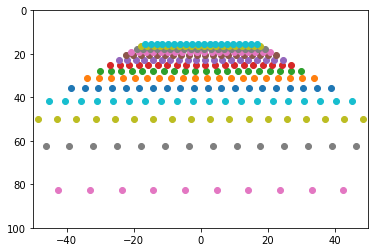

In [29]:
# print distance correspondence between mapping and image
for mapp in mappings:
    # i is the distance to depth plane and j is the distance inside depth plane
    plt.plot([j for _,j in mapp], [i for i,_ in mapp], 'o')

# set interval to image gt distances
plt.xlim([-50, 50])
plt.ylim([0, 100])
# invert y axis to set coordinates as in the image referential
plt.gca().invert_yaxis()
plt.show()

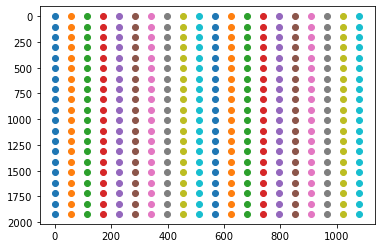

In [30]:
# print mappings on image
for px_mapp in mapping_pixel_cords:
    # i is the distance to depth plane and j is the distance inside depth plane
    plt.plot([j for _,j in px_mapp], [i for i,_ in px_mapp], 'o')
plt.gca().invert_yaxis()
plt.show()

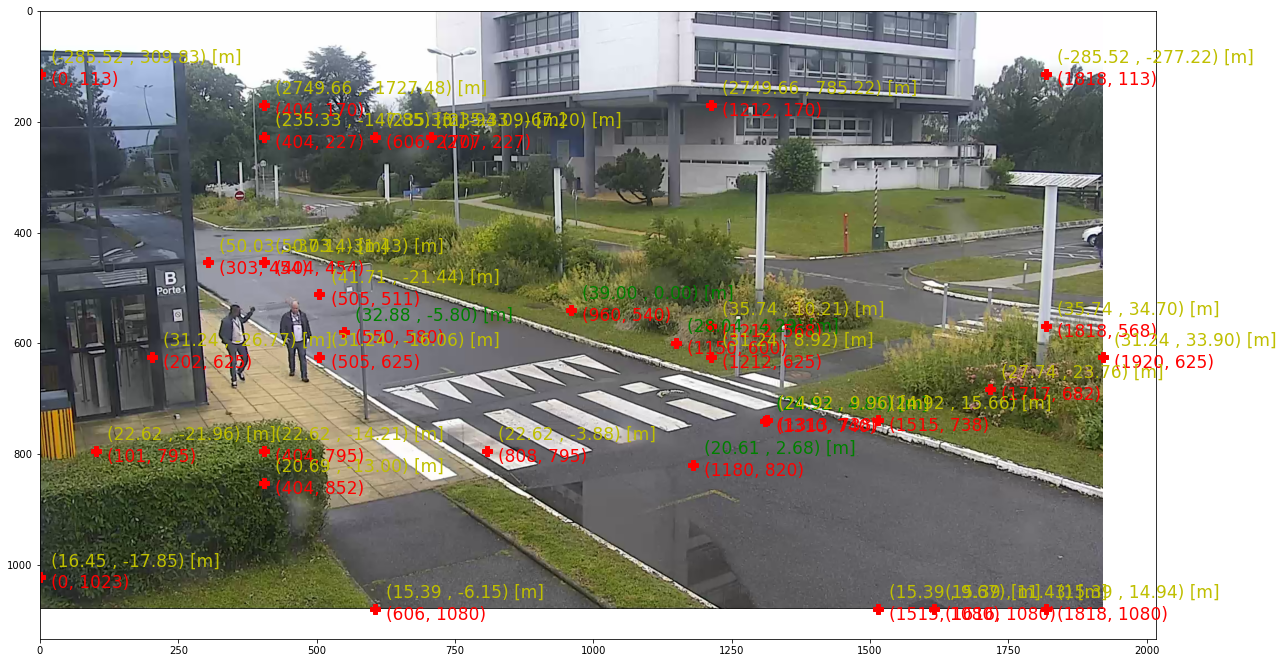

In [31]:
alfa = 20
plt.figure(figsize=(20,20))
plt.imshow(test_img)

# print the ground truth
# plot pixel and cartesian coordinates
for pixel_coord, cart_coord in zip(gt_pixel_coords, gt_cartesian_measures):
    label_pixel_coord = str((pixel_coord[0],pixel_coord[1]))
    label_cart_coord = '({:.2f} , {:.2f}) [m]'.format(cart_coord[0],cart_coord[1])

    plt.plot(pixel_coord[0], pixel_coord[1], 'P', c = 'r', markersize = '10')
    plt.text(pixel_coord[0]+alfa, pixel_coord[1]+alfa, label_pixel_coord, c = 'r', fontsize = 17)
    plt.text(pixel_coord[0]+alfa, pixel_coord[1]-alfa, label_cart_coord, c = 'g', fontsize = 17)



# print map coordinates over image
for mapp,px_mapp in zip(mappings, mapping_pixel_cords):
    # get distances and pixels
    for cart_coord, pixel_coord in zip(mapp, px_mapp):
        # plot random points
        if np.random.random() > 0.94:

            w, h = int(pixel_coord[0]), int(pixel_coord[1])
            label_pixel_coord = str((w, h))
            label_cart_coord = '({:.2f} , {:.2f}) [m]'.format(cart_coord[0],cart_coord[1])
            plt.plot(w, h, 'P', c = 'r', markersize = '10')
            plt.text(w+alfa, h+alfa, label_pixel_coord, c = 'r', fontsize = 17)
            plt.text(w+alfa, h-alfa, label_cart_coord, c = 'y', fontsize = 17)

plt.axis('on')
plt.show()

# Camera homography

In [32]:
filepath = os.path.join(video_path, filenames[0])
filepath

'../../datasets/NokiaVillarceauxVideoFeed/CALIBRATION/GAL-EXT-NORD-OUEST_2022-06-30_14h10min43s943ms.mp4'

In [33]:
# CHECKBOARD DIMENSION
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
CHECKERBOARD = (6,9)

In [34]:
# Defining the world coordinates for 3D points
objp = np.zeros((1, CHECKERBOARD[0] * CHECKERBOARD[1], 3), np.float32)
objp[0,:,:2] = np.mgrid[0:CHECKERBOARD[0], 0:CHECKERBOARD[1]].T.reshape(-1, 2)

In [35]:
np.mgrid[0:CHECKERBOARD[0], 0:CHECKERBOARD[1]]

array([[[0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1],
        [2, 2, 2, 2, 2, 2, 2, 2, 2],
        [3, 3, 3, 3, 3, 3, 3, 3, 3],
        [4, 4, 4, 4, 4, 4, 4, 4, 4],
        [5, 5, 5, 5, 5, 5, 5, 5, 5]],

       [[0, 1, 2, 3, 4, 5, 6, 7, 8],
        [0, 1, 2, 3, 4, 5, 6, 7, 8],
        [0, 1, 2, 3, 4, 5, 6, 7, 8],
        [0, 1, 2, 3, 4, 5, 6, 7, 8],
        [0, 1, 2, 3, 4, 5, 6, 7, 8],
        [0, 1, 2, 3, 4, 5, 6, 7, 8]]])

In [36]:
src_image = cv2.imread(filepath)

src_image = cv2.cvtColor(src_image, cv2.COLOR_BGR2RGB)
    
plt.figure(figsize=(10,10))
plt.imshow(src_image)
plt.axis('off')
plt.show()




error: OpenCV(4.5.3) /tmp/pip-req-build-afu9cjzs/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


In [ ]:
# Creating vector to store vectors of 3D points for each checkerboard image
objpoints = []
# Creating vector to store vectors of 2D points for each checkerboard image
imgpoints = []


In [ ]:
gray = cv2.cvtColor(src_image,cv2.COLOR_BGR2GRAY)

ret, corners = cv2.findChessboardCorners(gray, CHECKERBOARD, 
                                         cv2.CALIB_CB_ADAPTIVE_THRESH + cv2.CALIB_CB_FAST_CHECK + cv2.CALIB_CB_NORMALIZE_IMAGE)

In [ ]:
# refining pixel coordinates for given 2d points.

corners2 = cv2.cornerSubPix(gray, corners, (11,11),(-1,-1), criteria)

imgpoints.append(corners2)
objpoints.append(objp)

# Draw and display the corners

display_img = cv2.drawChessboardCorners(src_image, CHECKERBOARD, corners2, ret)


In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(display_img)
plt.axis('off')
plt.show()

In [ ]:
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, (WIDTH_RES, HEIGTH_RES), None, None)


In [ ]:
ret

In [ ]:
mtx

In [ ]:
imgpoints

In [ ]:
objpoints